# **Análisis de Modelos de Conjunto (Ensemble Models) en Regresión**

---

En el ámbito del aprendizaje automático, los modelos de conjunto (Ensemble Models) representan un enfoque poderoso para mejorar la precisión de las predicciones. Estos modelos combinan varios algoritmos individuales para reducir el error y mejorar la generalización. En este estudio, evaluamos y comparamos diferentes métodos de conjunto para estimar el valor de Item_Outlet_Sales, utilizando un árbol de decisión como referencia.

El objetivo es identificar el modelo con el menor Error Cuadrático Medio (MSE) y analizar qué tipo de método (Bagging o Boosting) ofrece el mejor rendimiento para este problema de regresión.

## 2. Desarrollo y Metodología

### 2.1.Cargar Librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
#Leer dataset
df = pd.read_csv('Train.csv')

In [3]:
#Análisis de datos en dataset
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
#Identificadores totales
df.Item_Identifier.value_counts()

,count
Item_Identifier,
FDW13,10
FDG33,10
NCY18,9
FDD38,9
DRE49,9
...,...
FDY43,1
FDQ60,1
FDO33,1


### 2.2.Preparación de Datos

In [5]:
# Rellenar missing values
df['Item_Weight'].fillna(df['Item_Weight'].median(), inplace=True) # LLENAMOS LOS MISSING DE Item_Weight CON LA MEDIANA'''
df['Outlet_Size'].fillna(df['Outlet_Size'].mode()[0], inplace=True) # LLENAMOS LOS MISSING DE Outlet_Size CON LA MODA'''

In [6]:
#Transformar categorias para agrupar los datos
df['Item_Type_Combined'] = df['Item_Identifier'].apply(lambda s: s[0:2]) # Tomamos los dos primeros caracteres
df['Item_Type_Combined'] = df['Item_Type_Combined'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})

df['Item_Type_Combined'].value_counts()

,count
Item_Type_Combined,
Food,6125
Non-Consumable,1599
Drinks,799


In [7]:
#Crear nueva columna con valor
df['Outlet_Years'] = 2013 - df['Outlet_Establishment_Year']

In [8]:
#Transformar variables categóricas
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})
df['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,3006


In [9]:
#LabelEncoder: Para transformar valores categoricos a numéricos en la misma columna
le = LabelEncoder()
df['Outlet'] = le.fit_transform(df['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
  df[i] = le.fit_transform(df[i])

In [10]:
#One-Hot Encoding (Dummies): Para transformar el resto de columnas categóricas a números
df = pd.get_dummies(df, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Type_Combined','Outlet'])

In [11]:
#Eliminar aquellas columnas que ya no nos interesan
df.drop(['Item_Type','Outlet_Establishment_Year', 'Item_Identifier', 'Outlet_Identifier'],axis=1,inplace=True)

In [12]:
df.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Outlet_Years,Item_Fat_Content_0,Item_Fat_Content_1,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,9.30,0.016047,249.8092,3735.1380,14,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
1,5.92,0.019278,48.2692,443.4228,4,False,True,False,False,True,...,False,False,False,True,False,False,False,False,False,False
2,17.50,0.016760,141.6180,2097.2700,14,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
3,19.20,0.000000,182.0950,732.3800,15,False,True,False,False,True,...,True,False,False,False,False,False,False,False,False,False
4,8.93,0.000000,53.8614,994.7052,26,True,False,False,False,True,...,False,True,False,False,False,False,False,False,False,False


### 2.2. División de Datos y Modelo Base

Los datos se dividen en:
* 80% entrenamiento (X_train, y_train).
* 20% prueba (X_test, y_test).

Como referencia, entrenamos un árbol de decisión (árbol simple) y calculamos su MSE.

In [13]:
#Separar características (X) y variable objetivo (y)
X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']

In [14]:
#  2.Dividir datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
#  3. Tipo de datos en: Item_Outlet_Sales
print("Tipo de Variable:", df['Item_Outlet_Sales'].dtype)
print("Valores:", df['Item_Outlet_Sales'].unique())

Tipo de Variable: float64
Valores: [3735.138   443.4228 2097.27   ... 7182.6504 3608.636  2778.3834]


La variable que queremos estimar es **Item_Outlet_Sales**, que representa el monto de ventas de un producto en una tienda. En este caso utilizamos modelos de **Regresión** cuando la **variable objetivo es un número continuo.**

In [16]:
#  4. Diccionario para almacenar los resultados
mse_scores = {}

El MSE del árbol de decisión se usa como base para comparar con otros modelos de conjunto.

In [17]:
#  Modelo 1: Árbol de Decisión
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt) #Calcula el Error Cuadrático Medio (MSE)

mse_scores["Decision Tree"] = mse_dt #guardar en diccionario

## 3. Evaluación de Modelos de Conjunto

### 3.1.Bagging Methods

In [18]:
#  Modelo 2: Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf) #Calcula el Error Cuadrático Medio (MSE)

mse_scores["Random Forest"] = mse_rf #guardar en diccionario

In [19]:
mse_rf

1166850.150235086

In [20]:
#  Modelo 3: Extra Trees Regressor
et = ExtraTreesRegressor(random_state=42)
et.fit(X_train, y_train)
y_pred_et = et.predict(X_test)
mse_et = mean_squared_error(y_test, y_pred_et) #Calcula el Error Cuadrático Medio (MSE)

mse_scores["Extra Trees"] = mse_et #guardar en diccionario

In [29]:
mse_et

1243818.4172009323

### 3.2. Boosting Methods


In [21]:
#  Modelo 4: AdaBoost Regressor
ab = AdaBoostRegressor(random_state=42)
ab.fit(X_train, y_train)
y_pred_ab = ab.predict(X_test)
mse_ab = mean_squared_error(y_test, y_pred_ab)  #Calcula el Error Cuadrático Medio (MSE)

mse_scores["AdaBoost"] = mse_ab #guardar en diccionario

In [30]:
mse_ab

1441503.584577862

In [22]:
#  Modelo 5: XGBoost
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)  #Calcula el Error Cuadrático Medio (MSE)

mse_scores["XGBoost"] = mse_xgb #guardar en diccionario

In [31]:
mse_xgb

1288927.3188855909

In [23]:
#  Modelo 6: LightGBM
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)  #Calcula el Error Cuadrático Medio (MSE)

mse_scores["LightGBM"] = mse_lgbm #guardar en diccionario

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 29
[LightGBM] [Info] Start training from score 2202.365232


In [32]:
mse_lgbm

1108696.3268060521

## 4. Comparación de Modelos y Resultados

Se almacenan los resultados en un diccionario y se presentan en una tabla ordenada.

In [33]:
#  Tabla de MSE
mse_comparison = pd.DataFrame.from_dict(mse_scores, orient='index', columns=['MSE'])
mse_comparison.sort_values(by="MSE", ascending=True, inplace=True)

pd.options.display.float_format = '{:.2f}'.format  # Formato de números
display(mse_comparison)

,MSE
LightGBM,1108696.33
Random Forest,1166850.15
Extra Trees,1243818.42
XGBoost,1288927.32
AdaBoost,1441503.58
Decision Tree,2204722.25


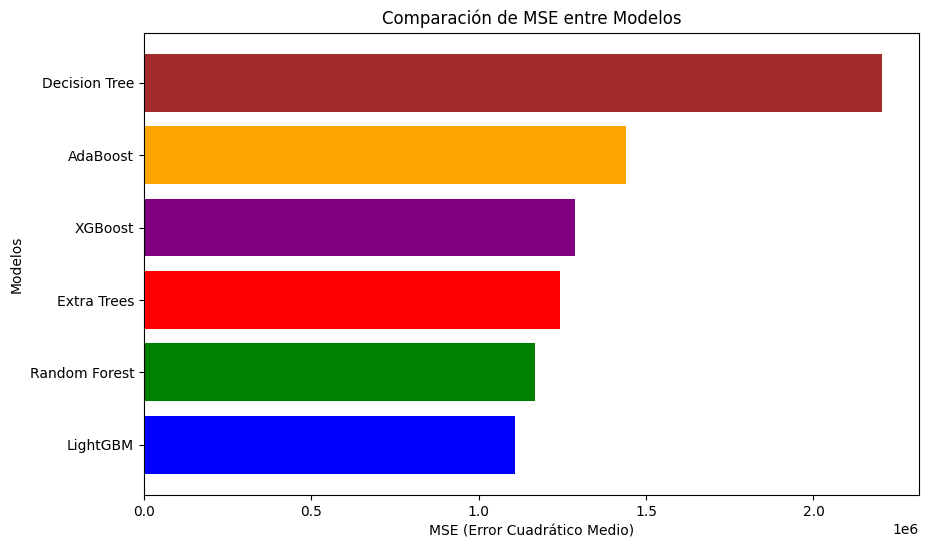

In [27]:
#  Visualización de comparación de errores
plt.figure(figsize=(10, 6))
plt.barh(mse_comparison.index, mse_comparison["MSE"], color=['blue', 'green', 'red', 'purple', 'orange', 'brown'])
plt.xlabel("MSE (Error Cuadrático Medio)")
plt.ylabel("Modelos")
plt.title("Comparación de MSE entre Modelos")
plt.show()


## 5. Conclusiones 

1. El árbol de decisión presenta el peor rendimiento, con el MSE más alto.
2. Los modelos de Bagging (Random Forest y Extra Trees) mejoran la precisión, pero no alcanzan el mejor resultado.
3. Los modelos de Boosting (XGBoost y LightGBM) tienen el menor error, siendo LightGBM el más efectivo en este caso.
4. LightGBM es el modelo más preciso según el MSE, indicando que es la mejor opción para este problema.